# 0 Imports

In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact
from sklearn.metrics import mean_squared_error
import seaborn as sns
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

In [182]:
# Constants

# path para guardar o dataset
PATH = './'
PATH_TRAIN_CSV = './data/train.csv'
PATH_TRAIN_IMG = './data/train_data.mat'
PATH_TEST_CSV = './data/test.csv'
PATH_TEST_IMG = './data/test_data.mat'
PATH_TRAIN = './processed-data/train_relations_not_null_data.csv'
PATH_TEST = './processed-data/test_relations_not_null_data.csv'

EPOCHS = 120
BATCH_SIZE = 30
LEARNING_RATE = 0.001

device = torch.device("cuda")

# definição classe para o dataset
class CSVDataset(Dataset):
  # ler o dataset
  def __init__(self, dataframe):
    # separar os inputs e os outputs
    self.y = torch.tensor(dataframe['age'].values, dtype=torch.float32)
    self.x = torch.tensor(dataframe.drop(columns='age').values, dtype=torch.float32)
    self.y = self.y.reshape((len(self.y), 1))
        
  # número de casos no dataset
  def __len__(self):
    return len(self.x)

  # retornar um caso
  def __getitem__(self, idx):
    label = self.y[idx]
    data = self.x[idx]       
    return [data, label]
  
  # retornar índices para casos de treino de de teste
  def get_splits(self, train_size, val_size):
    # calcular o split do houldout
    return random_split(self, [train_size, val_size])#, generator=torch.Generator().manual_seed(42))

# 1 Exploração e Preparação dos Dados

### Visualização dos dados

In [3]:
def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    return  train_np, test_np


def load_data(path_train_csv, path_train_img, path_test_csv, path_test_img):
    train_csv = pd.read_csv(path_train_csv, header=0)
    test_csv = pd.read_csv(path_test_csv, header=0)
    train_img, test_img = get_data_from_mat(path_train_img, path_test_img)
    return train_csv, test_csv, train_img, test_img


def visualize(image):
    plt.imshow(image, cmap="gray")    
    plt.show()      

def show_ds(ds):
    print("ds shape:",ds.shape)
    print("ds max:",np.max(ds))
    print("ds min:",np.min(ds))
    print("ds average:",np.average(ds))
    @interact
    def visualize_set(scan_index=(0,len(ds)-1)):
        visualize(ds[scan_index,:,:])

train_csv, test_csv, train_img, test_img = load_data(PATH_TRAIN_CSV, PATH_TRAIN_IMG, PATH_TEST_CSV, PATH_TEST_IMG)

In [ ]:
print("Data de treino:")
print(train_csv)
show_ds(train_img)
print("Data de Teste:")
print(test_csv)
show_ds(test_img)

### Preparação dos dados

In [5]:
def fix_sex_id_columns(train_csv, test_csv):
    for csv in [train_csv, test_csv]:
        female = csv['sex']
        male = []
        for person in female:
            if person==1:
                male.append(0)
            else:
                male.append(1)
        csv.drop('sex', axis='columns', inplace=True)
        csv['female']=female
        csv['male']=male
        csv.drop('id', axis='columns', inplace=True)
    return train_csv, test_csv
    
def img_to_list(img):
    tamanho = len(img)
    lista = []
    # triangular inferior sem diagonal
    for linha in range(tamanho):
        for coluna in range(linha):
            lista.append(img[linha][coluna])
    return lista

def imgs_to_matrix(imgs):
    matrix = []
    for img in imgs:
        matrix.append(img_to_list(img))
    return matrix

def join_data(train_csv, test_csv, train_img, test_img):
    train_matrix = imgs_to_matrix(train_img)
    test_matrix = imgs_to_matrix(test_img)
    train_data  = pd.concat([train_csv, pd.DataFrame(train_matrix)], axis=1)
    train_data.columns = list(train_csv.columns) + [f'rel-{i}' for i in range(len(train_matrix[0]))]
    test_data = pd.concat([test_csv, pd.DataFrame(test_matrix)], axis=1)
    test_data.columns = list(test_csv.columns) + [f'rel-{i}' for i in range(len(test_matrix[0]))]
    return train_data , test_data

def remove_non_relations(train_data, test_data):
    for data in [train_data, test_data]:
        data.drop('education', axis='columns', inplace=True)
        data.drop('female', axis='columns', inplace=True)
        data.drop('male', axis='columns', inplace=True)
    return train_data, test_data

def remove_education(train_data, test_data):
    for data in [train_data, test_data]:
        data.drop('education', axis='columns', inplace=True)
    return train_data, test_data

def remove_null_columns(train_data, test_data):
    columns_to_drop = []
    for column_name in test_data.columns:
        if (train_data[column_name] == 0).all() and (test_data[column_name] == 0).all():
            columns_to_drop.append(column_name)

    train_data = train_data.drop(columns_to_drop, axis=1)
    test_data = test_data.drop(columns_to_drop, axis=1)

    return train_data, test_data, columns_to_drop

In [6]:
train_csv, test_csv, train_img, test_img = load_data(PATH_TRAIN_CSV, PATH_TRAIN_IMG, PATH_TEST_CSV, PATH_TEST_IMG)
train_csv_fix, test_csv_fix = fix_sex_id_columns(train_csv, test_csv)

# everything (sex, education, relations)
train_complete_data, test_complete_data = join_data(train_csv_fix, test_csv_fix, train_img, test_img)

train_complete_data.to_csv('./processed-data/train_complete_data.csv', index=False)
test_complete_data.to_csv('./processed-data/test_complete_data.csv', index=False)

# without null relations (sex, education, not-null relations)
train_complete_not_null_data, test_complete_not_null_data, unrelated_brain_zones = remove_null_columns(copy.copy(train_complete_data), copy.copy(test_complete_data))

train_complete_not_null_data.to_csv('./processed-data/train_complete_not_null_data.csv', index=False)
test_complete_not_null_data.to_csv('./processed-data/test_complete_not_null_data.csv', index=False)

# only sex and not-null relations
train_sex_not_null_data, test_sex_not_null_data = remove_education(copy.copy(train_complete_not_null_data), copy.copy(test_complete_not_null_data))

train_sex_not_null_data.to_csv('./processed-data/train_sex_not_null_data.csv', index=False)
test_sex_not_null_data.to_csv('./processed-data/test_sex_not_null_data.csv', index=False)

# only not-null relations
train_relations_not_null_data, test_relations_not_null_data = remove_non_relations(copy.copy(train_complete_not_null_data), copy.copy(test_complete_not_null_data))

train_relations_not_null_data.to_csv('./processed-data/train_relations_not_null_data.csv', index=False)
test_relations_not_null_data.to_csv('./processed-data/test_relations_not_null_data.csv', index=False)

# only relations (null and not-null relations)
train_relations_data, test_relations_data = remove_non_relations(copy.copy(train_complete_data), copy.copy(test_complete_data))

train_relations_data.to_csv('./processed-data/train_relations_data.csv', index=False)
test_relations_data.to_csv('./processed-data/test_relations_data.csv', index=False)


Complete:
   age  education  female  male  rel-0     rel-1  rel-2  rel-3    rel-4   
0   13          7       1     0    0.0  0.131525    0.0    0.0  0.13695  \

   rel-5  ...  rel-3995  rel-3996  rel-3997  rel-3998  rel-3999  rel-4000   
0    0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0  \

   rel-4001  rel-4002  rel-4003  rel-4004  
0  0.585006       0.0  0.280606       0.0  

[1 rows x 4009 columns]
   education  female  male  rel-0     rel-1  rel-2  rel-3     rel-4     rel-5   
0         13       0     1    0.0  0.140891    0.0    0.0  0.158141  0.034232  \

   rel-6  ...  rel-3995  rel-3996  rel-3997  rel-3998  rel-3999  rel-4000   
0    0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0  \

   rel-4001  rel-4002  rel-4003  rel-4004  
0  0.612109       0.0  0.193069       0.0  

[1 rows x 4008 columns]

Complete without null relations:
   age  education  female  male     rel-1  rel-3    rel-4  rel-5     rel-8   
0   13          7       1  

### Seleção dos dados

In [81]:
def prepare_train_data_loaders(path_train):
    # Split the data into training and validation sets
    df = pd.read_csv(path_train, header=0)
    train_size = 90
    val_size = 22

    # Create the training and validation datasets
    dataset = CSVDataset(df)
    train, validation = dataset.get_splits(train_size, val_size)

    # Create the training and validation dataloaders
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)

    return train_dl, val_dl, train_dl_all, val_dl_all, df.shape[1]-1

90 casos de treino média 43.977779388427734 || 22 casos de validação média 45.681819915771484


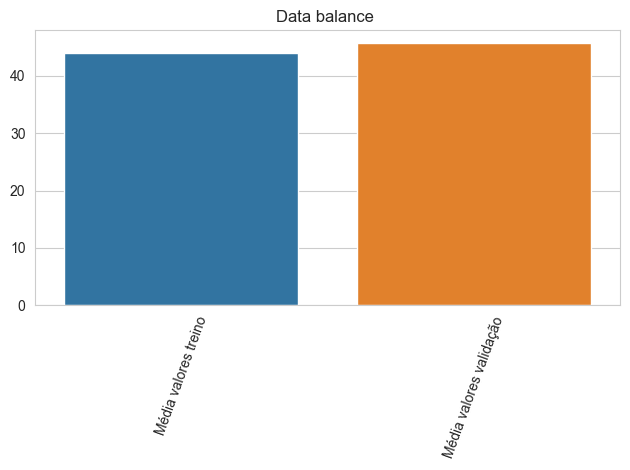

In [185]:
def visualize_holdout_balance(train_dl_all, val_dl_all):
    _, y_train = next(iter(train_dl_all))
    _, y_test = next(iter(val_dl_all))
    sns.set_style('whitegrid')
    casos_treino=len(y_train)
    casos_val=len(y_test)
    print(f'{casos_treino} casos de treino média {np.mean(y_train.numpy())} || {casos_val} casos de validação média {np.mean(y_test.numpy())}')
    grafico=sns.barplot(x=['Média valores treino','Média valores validação'],
    y=[np.mean(y_train.numpy()), np.mean(y_test.numpy())])
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_balance_MLP.png')
    plt.show()

train_dl, val_dl, train_dl_all, val_dl_all, dim_num = prepare_train_data_loaders(PATH_TRAIN)

visualize_holdout_balance(train_dl_all, val_dl_all)

In [8]:
from IPython.display import display

def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=None)
    display(df)
def visualize_dataset(train_dl, val_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(val_dl.dataset)}")
    x, y = next(iter(train_dl)) # fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    #print(y)
    
visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, val_dl)

,0,1,2,3,4,5,6,7,8,9,...,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202
0,age,rel-1,rel-3,rel-4,rel-5,rel-8,rel-13,rel-14,rel-15,rel-17,...,rel-3975,rel-3977,rel-3979,rel-3981,rel-3989,rel-3993,rel-3997,rel-3999,rel-4001,rel-4003
1,13,0.13152513068295066,0.0,0.13695039151507568,0.0,0.1463094835282487,0.08504357235067955,0.0,0.27153768530795785,0.6941960106503965,...,0.0,0.0,0.0,0.014926682256188676,0.0,0.0,0.0,0.0,0.5850060523860224,0.2806062271251331
2,14,0.11770352725560888,0.0,0.13299809511232405,0.037714477776214936,0.11342491582310929,0.10540277848429594,0.0,0.316890214857591,0.7569372231801426,...,0.0,0.0,0.0,0.031810609502218194,0.0,0.0,0.0,0.0,0.5994370017818766,0.20747818936911436
3,15,0.15580596397166746,0.0,0.1654291346173953,0.02227817462109693,0.09607963318316486,0.08788987272325399,0.0,0.3480716475756247,0.7844514493117679,...,0.0,0.0,0.0,0.021235216425020506,0.01804999835021417,0.0,0.0,0.0,0.6303735077739404,0.24647167768599754
4,15,0.14521446386863182,0.0,0.1624925814199255,0.0,0.12411458477169271,0.09794939291935065,0.0,0.3102695776218635,0.8006706490445937,...,0.0,0.0,0.0,0.01512992626682297,0.0,0.0,0.0,0.0,0.5625047108732929,0.2878876128467465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,77,0.21576667491869883,0.0,0.18494193783241825,0.01944638473680701,0.1099718901063309,0.1080905684647715,0.0,0.39033165627576394,0.7345744111069945,...,0.03316718489713255,0.015108487167287368,0.01643362637840082,0.056483035772704214,0.0,0.0,0.0,0.011150472478070992,0.6602918558628459,0.3026753383068725
109,67,0.1430050115257508,0.0,0.12435010951472804,0.0,0.09018890248147972,0.08936694625523896,0.0,0.30638034663390734,0.7568276622137461,...,0.0,0.013165506769402877,0.029519462267824488,0.05196410878016795,0.0,0.013097722203527673,0.011170836931819469,0.019141254000135794,0.6304154549754257,0.2041253280576364
110,55,0.1160847843891602,0.0,0.15640598132494415,0.020947137569371364,0.12258930443742344,0.09132464671190622,0.0,0.29094128118908275,0.8008432098836037,...,0.0,0.0,0.0,0.034193295163286515,0.010497958537702952,0.0,0.0,0.0,0.5743547251988937,0.24678357194266243
111,76,0.15665442423941386,0.0,0.16661323459706648,0.04646440036672482,0.0912442211721474,0.14748423338389025,0.017150519037560014,0.3575395968104339,0.6551286183171472,...,0.0,0.0,0.0,0.05149721459467968,0.012696512221254272,0.019894077761544175,0.010225005174065927,0.0,0.6310571080259276,0.21625939656444373


Quantidade de casos de Treino:90
Quantidade de casos de Teste:22
Shape tensor batch casos treino, input: torch.Size([30, 1202]), output: torch.Size([30, 1])
Shape tensor batch casos validação, input: torch.Size([22, 1202]), output: torch.Size([22, 1])


# 2 Definir o Modelo

In [213]:
class MLP(Module):
    def __init__(self, num_inputs, num_hidden=[40,25,15]):
        super(MLP, self).__init__()
        # input -> hidden 1
        self.hidden1 = Linear(num_inputs, num_hidden[0] )
        xavier_uniform_(self.hidden1.weight)
        self.act1 = ReLU()
        
        # hidden 1 --> hidden 2
        self.hidden2 = Linear(num_hidden[0],num_hidden[1])
        xavier_uniform_(self.hidden2.weight)
        self.act2 = ReLU()
            
        # hidden 2 --> hidden 3
        self.hidden3 = Linear(num_hidden[1],num_hidden[2])
        xavier_uniform_(self.hidden3.weight)
        self.act3 = ReLU()
        
        # hidden 3 --> hidden 4
        self.hidden4 = Linear(num_hidden[2],1)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = ReLU()

        # hidden 4 --> output
        # self.hidden5 = Linear(num_hidden[3],1)
        # xavier_uniform_(self.hidden5.weight)
        # self.act5 = ReLU()

    def forward(self, X):
        # start --> hidden1
        X = self.hidden1(X)
        X = self.act1(X)
        
        # hidden 1 --> hidden 2
        X = self.hidden2(X)
        X = self.act2(X)
        
        # hidden 2 --> hidden 3
        X = self.hidden3(X)
        X = self.act3(X)
        
        # hidden 3 --> hidden 4
        X = self.hidden4(X)
        # X = self.act4(X)
        
        # hidden 4 --> output
        # X = self.hidden5(X)
        # X = self.act5(X)
        return X

model = MLP(dim_num)
print(summary(model, input_size=(BATCH_SIZE, dim_num), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [30, 1]                   --
├─Linear: 1-1                            [30, 40]                  48,120
├─ReLU: 1-2                              [30, 40]                  --
├─Linear: 1-3                            [30, 30]                  1,230
├─ReLU: 1-4                              [30, 30]                  --
├─Linear: 1-5                            [30, 20]                  620
├─ReLU: 1-6                              [30, 20]                  --
├─Linear: 1-7                            [30, 10]                  210
├─ReLU: 1-8                              [30, 10]                  --
├─Linear: 1-9                            [30, 1]                   11
Total params: 50,191
Trainable params: 50,191
Non-trainable params: 0
Total mult-adds (M): 1.51
Input size (MB): 0.14
Forward/backward pass size (MB): 0.02
Params size (MB): 0.20
Estimated Total Size (MB): 0.37


# 3 Treinar o Modelo

In [10]:
def train_model(train_dl, val_dl, model, criterion, optimizer, epochs, file_path):
    liveloss = PlotLosses()
    for epoch in range(epochs):
        logs = {} # para o livelossplot
        
        # Train phase
        model.train() 
        epoch_loss = 0
        epoch_rmse = 0
        for batch_i, (inputs, labels) in enumerate(train_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            rmse = np.sqrt(mean_squared_error(labels.reshape((len(labels), 1)).cpu().numpy(), outputs.detach().cpu().numpy()))
            loss.backward()
            optimizer.step()


            # Accumulate the loss and RMSE
            epoch_loss += loss.item()
            epoch_rmse += rmse.item()
        
        logs['loss'] = epoch_loss / len(train_dl)
        logs['rmse'] = epoch_rmse / len(train_dl)


        # Validation phase
        model.eval()
        val_loss = 0
        val_rmse = 0
        for batch_i, (val_inputs, val_labels) in enumerate(val_dl):
            # Perform forward pass
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            
            # Calculate the loss and RMSE
            val_loss_batch = criterion(val_outputs, val_labels)
            val_rmse_batch = np.sqrt(mean_squared_error(val_labels.reshape((len(val_labels), 1)).cpu().numpy(), val_outputs.detach().cpu().numpy()))
            
            # Accumulate the loss and RMSE
            val_loss += val_loss_batch.item()
            val_rmse += val_rmse_batch.item()

        logs['val_loss'] = val_loss / len(val_dl)
        logs['val_rmse'] = val_rmse / len(val_dl)
   
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,file_path) # para gravar o modelo no final do treino

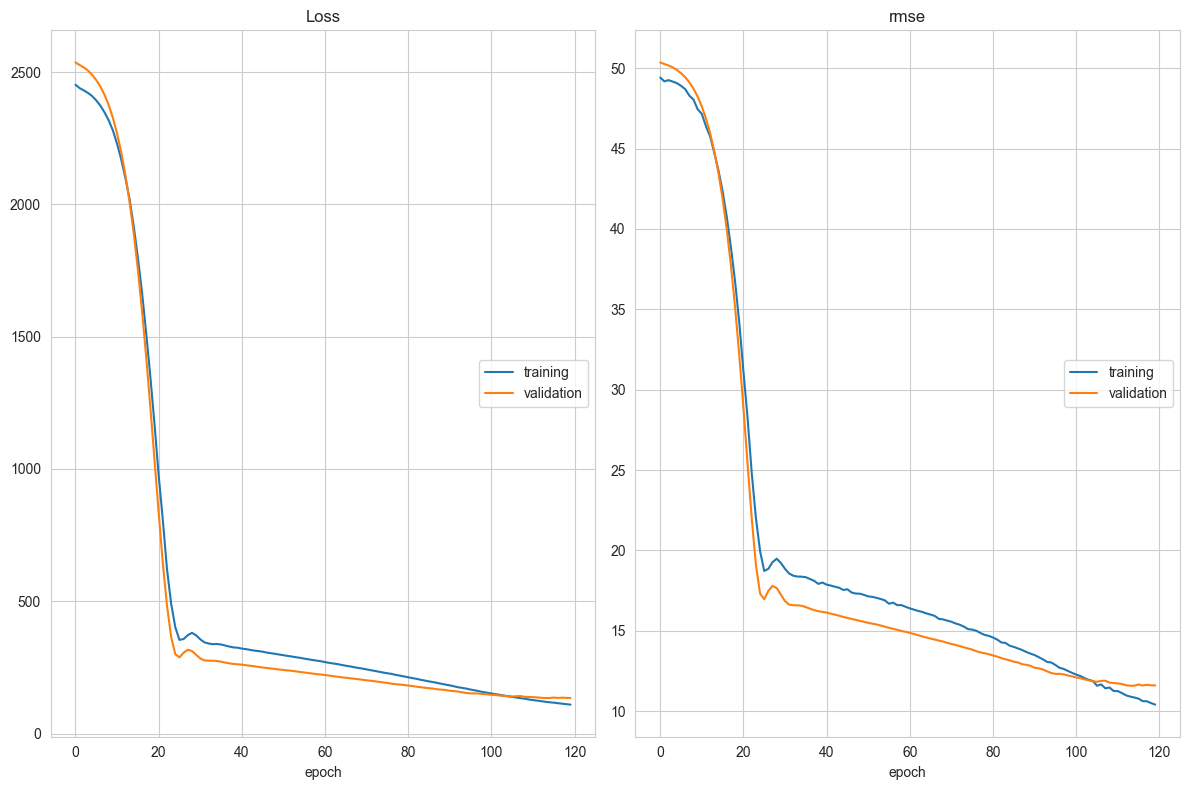

Loss
	training         	 (min:  109.222, max: 2452.082, cur:  109.222)
	validation       	 (min:  134.064, max: 2536.487, cur:  134.499)
rmse
	training         	 (min:   10.404, max:   49.425, cur:   10.404)
	validation       	 (min:   11.579, max:   50.364, cur:   11.597)
Tempo gasto: 77.54090759999963 segundos


In [229]:
model = MLP(dim_num)
model.cuda()
device = torch.device("cuda")

criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

starttime = time.perf_counter()
train_model(train_dl, val_dl, model, criterion, optimizer, EPOCHS, './models/MLP_Hugo.pth')
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

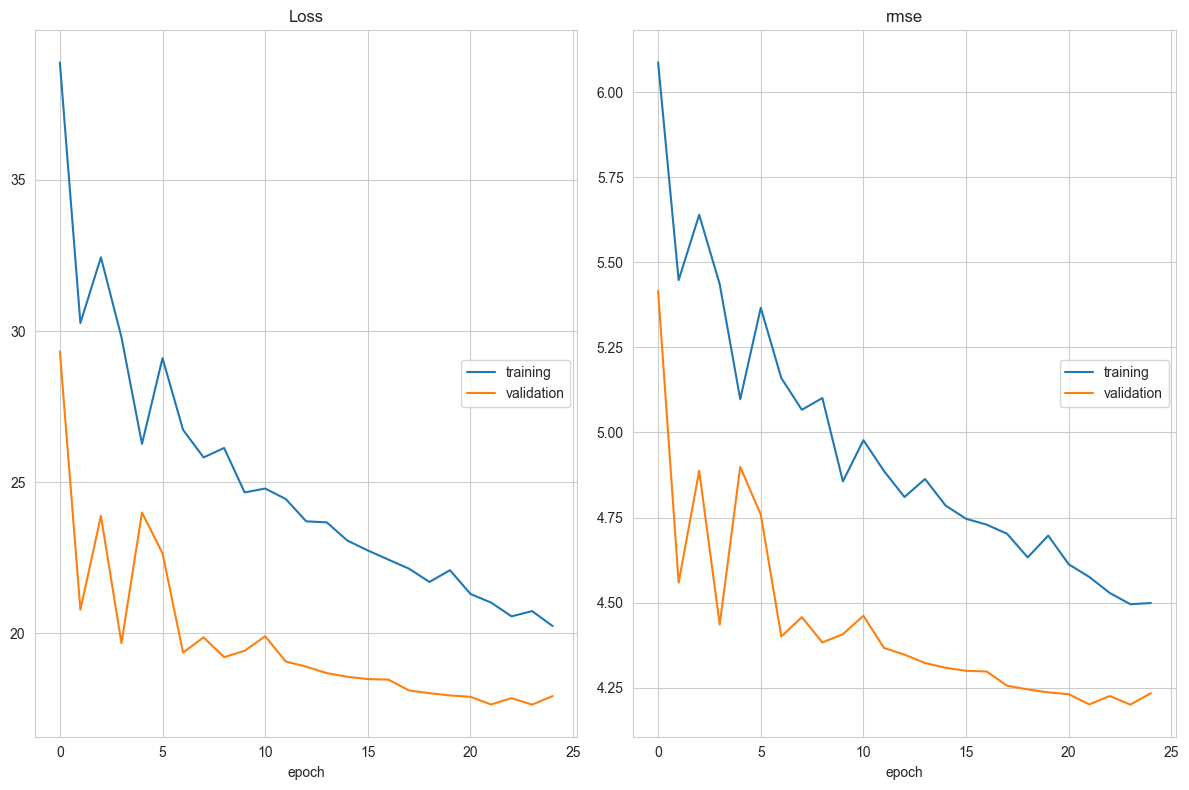

Loss
	training         	 (min:   20.241, max:   38.887, cur:   20.241)
	validation       	 (min:   17.641, max:   29.328, cur:   17.923)
rmse
	training         	 (min:    4.495, max:    6.088, cur:    4.499)
	validation       	 (min:    4.200, max:    5.416, cur:    4.234)
Tempo gasto: 88.43263490000027 segundos


In [222]:
from sklearn.model_selection import KFold

# Define the number of folds
k = 5
ep = 25

# Perform cross-validation
data = pd.read_csv(PATH_TRAIN, header=0)
kf = KFold(n_splits=k, shuffle=True)
timelist=[]

for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{k}")
    
    # Split the data into training and validation sets for this fold
    train_data = CSVDataset(data.iloc[train_index])
    val_data = CSVDataset(data.iloc[val_index])
    
    # Create train and validation data loaders
    train_dl2 = DataLoader(train_data, batch_size=len(train_dl2), shuffle=True)
    val_dl2 = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

    # Load model
    try:
        model2= torch.load("./models/MLP_Hugo-cross.pth") ### modelo treinado anteriormente
    except:
        # model2= torch.load("./models/MLP_Hugo.pth") ### modelo treinado anteriormente
        model2 = MLP(dim_num)
        model2.cuda()
    model2.to(device)

    # Train the model
    criterion2 = nn.MSELoss()
    # criterion2 = nn.L1Loss()
    # optimizer2 = SGD(model2.parameters(), lr=LEARNING_RATE) 
    optimizer2 = Adam(model2.parameters(), lr=LEARNING_RATE)
    
    starttime = time.perf_counter()
    train_model(train_dl2, val_dl2, model2, criterion2, optimizer2, ep, './models/MLP_Hugo-cross.pth')
    endtime = time.perf_counter()
    timelist.append(endtime - starttime)

print(f"Tempo gasto: {sum(timelist)} segundos")

# 4 Avaliar o Modelo

In [238]:
def evaluate_model(val_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(val_dl):
        inputs=inputs.to(device)
        labels=labels.to(device)
        # avaliar o modelo com os casos de teste
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        actual = actual.reshape((len(actual), 1))
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
        break

    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

# avaliar o modelo
actual_values, predictions = evaluate_model(val_dl, model)
#actuals, predictions = evaluate_model(train_dl, model)
for r,p in zip(actual_values, predictions):
    print(f'real:{r} previsão:{p}')
# calcular a accuracy
mse = mean_squared_error(actual_values, predictions)
print(f'MSE: {mse:0.3f}, RMSE: {np.sqrt(mse):0.3f}\n')

real:[51.] previsão:[48.98125]
real:[56.] previsão:[54.35016]
real:[18.] previsão:[22.095924]
real:[68.] previsão:[65.64284]
real:[18.] previsão:[18.783293]
real:[19.] previsão:[23.63249]
real:[65.] previsão:[66.19475]
real:[57.] previsão:[64.1789]
real:[15.] previsão:[17.515554]
real:[68.] previsão:[67.35586]
real:[46.] previsão:[35.143707]
real:[15.] previsão:[14.672805]
real:[65.] previsão:[60.451714]
real:[79.] previsão:[74.2466]
real:[71.] previsão:[77.93444]
real:[40.] previsão:[29.455172]
real:[16.] previsão:[17.390112]
real:[40.] previsão:[35.819958]
real:[62.] previsão:[61.65704]
real:[58.] previsão:[58.075]
real:[59.] previsão:[62.87853]
real:[19.] previsão:[20.306997]
MSE: 21.260, RMSE: 4.611



# 5 Testar o Modelo

In [210]:
# definição classe para o dataset
class CSVTestDataset(Dataset):
  # ler o dataset
  def __init__(self, dataframe):
    # separar os inputs e os outputs
    self.x = torch.tensor(dataframe.values, dtype=torch.float32)
        
  # número de casos no dataset
  def __len__(self):
    return len(self.x)

  # retornar um caso
  def __getitem__(self, idx):
    data = self.x[idx]       
    return data
  
def prepare_test_data_loaders(path_train):
  test_df = pd.read_csv(path_train, header=0)

  # Create the training and validation datasets
  test = CSVTestDataset(test_df)

  # Create the training and validation dataloaders
  test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
  test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)

  return test_dl, test_dl_all

In [237]:
from collections import Counter


test_dl, test_dl_all = prepare_test_data_loaders(PATH_TEST)

model = torch.load('./Models/MLP_Hugo-cross.pth')
model.eval()

predictions_ = []

with torch.no_grad():
    for data in test_dl:
        data = data.to(device)
        output = model(data)
        predictions_.extend(output.tolist())

predictions = []
for prediction in predictions_:
    for p in prediction:
        predictions.append(int(p))

result = pd.read_csv('./data/example_submission.csv')
result['age']=predictions
result.to_csv('./results/res.csv', index=False)


res = pd.read_csv('./results/res.csv')
sub1 = pd.read_csv('./results/sub1.csv')
res['agesub1']=sub1['age']
res['dif']=sub1['age']-res['age']
print(res)
print(sum(res['dif']))
print(sum(abs(res['dif'])))

    id  age  agesub1  dif
0    1   23       16   -7
1    2   22       15   -7
2    3   18       16   -2
3    4   22       16   -6
4    5   19       18   -1
5    6   24       25    1
6    7   54       76   22
7    8   43       69   26
8    9   60       76   16
9   10   69       63   -6
10  11   68       69    1
11  12   73       69   -4
12  13   73       69   -4
13  14   71       62   -9
14  15   17       16   -1
15  16   20       16   -4
16  17   21       16   -5
17  18   27       15  -12
18  19   18       18    0
19  20   28       15  -13
20  21   49       68   19
21  22   58       58    0
22  23   58       69   11
23  24   78       69   -9
24  25   56       69   13
25  26   65       76   11
26  27   60       55   -5
27  28   68       69    1
26
216
